# Reducing score dimensionality and finding similar images

In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
import collections

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# read in hdf5 file
# image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [3]:
# read in scores
# 'animals', 'nature', 'text', 'maps', 'people', 'seals', 'miniatures', 
# 'objects', 'architecture', 'decorations', 'landscapes', 'diagrams'
scores_data = h5py.File('/data/all_scores_12class.hdf5','r')
print scores_data["Chunk1"][400]
print np.max(scores_data["Chunk1"][400])

[  3.11982818e-02   8.32416627e-05   5.60833097e-01   2.79666303e-04
   8.79068300e-02   4.45149913e-02   1.96852779e-04   6.89041018e-02
   5.22559458e-05   2.01110378e-01   3.77605017e-03   1.14434422e-03]
0.560833096504


## Fixing the image_metadata

In [7]:
categories = ['animals', 'nature', 'text', 'maps', 'people', 'seals', 'miniatures', \
'objects', 'architecture', 'decorations', 'landscapes', 'diagrams']
for idx in range(970000, 970218):
    chk = idx/5000
    i = idx % 5000
    scores = scores_data["Chunk{}".format(chk)][i]
    image_metadata[idx][-1] = categories[np.argmax(scores)]

In [10]:
image_metadata[970217]

['000733402_0_000003_1_', '1946', 'e', 'decorations']

In [12]:
pickle.dump((image_metadata, book_metadata, image_to_idx), open("/data/all_metadata_1M_tags.pkl", 'w'))

## Make hdf5 file for all_scores_pool3

In [4]:
indices = range(0, 970217, 5000)[1:]
indices.append(970217)
print indices

[5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000, 505000, 510000, 515000, 520000, 525000, 530000, 535000, 540000, 545000, 550000, 555000, 560000, 565000, 570000, 575000, 580000, 585000, 590000, 595000, 600000, 605000, 610000, 615000, 620000, 625000, 630000, 635000, 640

In [5]:
chunk_nums = [(i+4999)/5000 - 1 for i in indices]
print chunk_nums

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]


In [31]:
## Make hdf5 file for all scores
all_scores = h5py.File("/data/all_scores_pool3.hdf5", 'w')
for i in indices:  # looping over each pickle
    if i % 20000 == 0: print i

    try:
        chunk_file = "/data/nearest_neighbor_tagging/pool3_softmax_scores_new/scores_{}.pkl".format(i)
        scores = pickle.load(open(chunk_file, 'r'))    
    except:
        continue
    temp = np.empty((5000,2048))
    for index in range(5000):
        score_index = i - 5000 + index  # Chunk 2: temp[5] = scores[15000 - 5000 + 5] = scores[10005]
        if score_index not in scores: continue
        temp[index] = scores[score_index]
        
    chunk_num = (i+4999)/5000 - 1 # see above -- mapping so we get chunks 0 to 194
    all_scores.create_dataset("Chunk{}".format(chunk_num), data=temp)

all_scores.close()

20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000
860000
880000
900000
920000
940000
960000


In [20]:
chunk_file = "/data/nearest_neighbor_tagging/pool3_softmax_scores_new/scores_{}.pkl".format(15000)
scores = pickle.load(open(chunk_file, 'r'))    
scores[10500]

array([ 0.0918475 ,  0.00499424,  0.07765165, ...,  0.42414767,
        0.00180882,  0.93171066], dtype=float32)

In [24]:
all_scores.close()

ValueError: Not a file id (Not a file id)

## What is the distribution of scores for each category? 

In [5]:
max_scores = collections.defaultdict(lambda: [])
for idx in range(970218):
    chk = idx/5000
    i = idx % 5000
    scores = scores_data["Chunk{}".format(chk)][i]
    max_scores[np.argmax(scores)].append(np.max(scores))

In [5]:
for category in max_scores:
    num = np.sum(np.array(max_scores[category]) > 0.9)
    pct = float(num)/len(max_scores[category])
    print category, num, pct

0 17301 0.307666316931
1 21526 0.268873344991
2 22701 0.502746157594
3 38167 0.652873759836
4 118582 0.62226863416
5 25653 0.460358193956
6 24489 0.684069387413
7 22545 0.315120764844
8 57362 0.548818875037
9 68692 0.706300896603
10 32259 0.271503837867
11 30566 0.544955338836


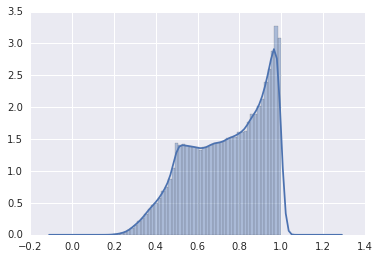

In [47]:
sns.distplot(np.array(max_scores[10]))

## Getting matrices for all categories, running PCA, and making distance matrices: Test

In [6]:
all_scores = h5py.File("/data/all_scores_pool3.hdf5", 'r')
all_scores["Chunk0"][:10]

array([[ 1.05541706,  0.00310066,  0.05723139, ...,  0.22937153,
         0.01113083,  0.00978714],
       [ 0.76485813,  0.        ,  0.07829402, ...,  0.00653851,
         0.05295077,  0.01116185],
       [ 1.0298841 ,  0.21995971,  0.11545297, ...,  0.0188979 ,
         0.04670588,  0.        ],
       ..., 
       [ 0.37604493,  0.25639302,  1.87961304, ...,  0.44600505,
         0.02618813,  0.33498245],
       [ 1.0336951 ,  0.04561228,  0.60564977, ...,  0.00628665,
         0.54624897,  0.61161304],
       [ 0.37604493,  0.25639302,  1.87961304, ...,  0.44600505,
         0.02618813,  0.33498245]])

In [19]:
categories = ['animals', 'nature', 'text', 'maps', 'people', 'seals', 'miniatures', \
'objects', 'architecture', 'decorations', 'landscapes', 'diagrams']
def process_category(cat):
    # make the matrix
    category_name = categories[cat]
    mat = np.zeros((len(max_scores[cat]), 2048))
    idx_in_cat = []
    
    ctr = 0
    for idx in xrange(100000):
        chk = idx/5000
        i = idx % 5000
        if category_name == image_metadata[idx][-1]: 
            mat[ctr,:] = all_scores["Chunk{}".format(chk)][i]
            idx_in_cat.append(idx)
            ctr += 1
            
    mat = mat[0:ctr,:]
            
    return mat, idx_in_cat

In [20]:
%time mat, indices = process_category(1)

CPU times: user 1.43 s, sys: 178 ms, total: 1.6 s
Wall time: 6.69 s


In [21]:
mat.shape

(6113, 2048)

In [22]:
pca = PCA(n_components=40, whiten=True)
np.random.seed(5)
rand_rows = np.random.random_integers(0, np.shape(mat)[0], 100)  # take 10k rows randomly from the whole matrix
%time pca.fit(mat[rand_rows,:])

CPU times: user 38.4 ms, sys: 4.11 ms, total: 42.5 ms
Wall time: 43.7 ms


PCA(copy=True, n_components=40, whiten=True)

In [23]:
%time pool3_pca_scores = pca.transform(mat)

CPU times: user 776 ms, sys: 24 ms, total: 800 ms
Wall time: 799 ms


In [24]:
pool3_pca_scores.shape

(6113, 40)

In [25]:
from sklearn.metrics.pairwise import pairwise_distances
%time dist = pairwise_distances(pool3_pca_scores[0:1000,:], n_jobs=-1)
dist.shape

CPU times: user 349 ms, sys: 28.2 ms, total: 377 ms
Wall time: 460 ms


(1000, 1000)

In [33]:

# distance matrix + get the nearest 
print "Calculating the distance matrix"
dist = pairwise_distances(pool3_pca_scores, n_jobs=-1)
idx_to_neighbors = {}
for i in range(dist.shape[0]):
    if i % 2000 == 0: print i
    idx = indices[i]

    neighbor_ranks = np.array(dist[i,:]).argsort()  # returns a list of the column indices in order from smallest to largest
    idx_to_neighbors[idx] = [(indices[z], dist[i,z]) for z in neighbor_ranks[1:20]]  # skip the first one (distance = 0)


Calculating the distance matrix
0
2000
4000
6000


In [26]:
idx_to_neighbors = {}
for i in range(dist.shape[0]):
    if i % 2000 == 0: print i
    idx = indices[i]

    neighbor_ranks = np.array(dist[i,:]).argsort()  # returns a list of the column indices in order from smallest to largest
    idx_to_neighbors[idx] = [(indices[z], dist[i,z]) for z in neighbor_ranks[1:20]]  # skip the first one (distance = 0)

0


## Getting matrices for all categories, running PCA, and making distance matrices: run for all

In [4]:
all_scores = h5py.File("/data/all_scores_pool3.hdf5", 'r')
all_scores["Chunk0"][:10]

array([[ 1.05541706,  0.00310066,  0.05723139, ...,  0.22937153,
         0.01113083,  0.00978714],
       [ 0.76485813,  0.        ,  0.07829402, ...,  0.00653851,
         0.05295077,  0.01116185],
       [ 1.0298841 ,  0.21995971,  0.11545297, ...,  0.0188979 ,
         0.04670588,  0.        ],
       ..., 
       [ 0.37604493,  0.25639302,  1.87961304, ...,  0.44600505,
         0.02618813,  0.33498245],
       [ 1.0336951 ,  0.04561228,  0.60564977, ...,  0.00628665,
         0.54624897,  0.61161304],
       [ 0.37604493,  0.25639302,  1.87961304, ...,  0.44600505,
         0.02618813,  0.33498245]])

In [5]:
num_images = collections.defaultdict(lambda: 0)
for idx in xrange(970218):
    chk = idx/5000
    i = idx % 5000
    num_images[image_metadata[idx][-1]] += 1
num_images

defaultdict(<function __main__.<lambda>>,
            {'animals': 56233,
             'architecture': 104519,
             'decorations': 97256,
             'diagrams': 56089,
             'landscapes': 118816,
             'maps': 58460,
             'miniatures': 35799,
             'nature': 80060,
             'objects': 71544,
             'people': 190564,
             'seals': 55724,
             'text': 45154})

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
categories = ['animals', 'nature', 'text', 'maps', 'people', 'seals', 'miniatures', \
'objects', 'architecture', 'decorations', 'landscapes', 'diagrams']

def process_category_with_pca(cat, cross=False):
    # make the matrix
    print "Making matrix"
    category_name = categories[cat]
    mat = np.zeros((num_images[category_name], 2048))
    true_indices = []
    
    ctr = 0
    for idx in xrange(970218):
    #for idx in xrange(20000):  ###test
        chk = idx/5000
        i = idx % 5000
        if category_name == image_metadata[idx][-1]: 
            mat[ctr,:] = all_scores["Chunk{}".format(chk)][i]
            true_indices.append(idx)
            ctr += 1
    #mat = mat[0:ctr,:]  ###test
    print len(true_indices), mat.shape

    # do PCA
    print "Doing PCA"
    pca = PCA(n_components=40, whiten=True)
    np.random.seed(5)
    rand_rows = np.random.random_integers(0, np.shape(mat)[0], 10000)  # take 10k rows randomly from the whole matrix
    #rand_rows = np.random.random_integers(0, np.shape(mat)[0], 100) ### test # take 10k rows randomly from the whole matrix
    pca.fit(mat[rand_rows,:])
    pool3_pca_scores = pca.transform(mat)
    
    # distance matrix + get the nearest 
    print "Calculating the distance matrix"
    
    if not cross:
        dist = pairwise_distances(pool3_pca_scores, n_jobs=-1)
        print dist.shape[0]

        idx_to_neighbors = {}
        for i in range(dist.shape[0]):
            if i % 2000 == 0: print i
            idx = true_indices[i]

            neighbor_ranks = np.array(dist[i,:]).argsort()  # returns a list of the column indices in order from smallest to largest
            idx_to_neighbors[idx] = [(true_indices[z], dist[i,z]) for z in neighbor_ranks[1:20]]  # skip the first one (distance = 0)
    else:
        idx_to_neighbors = {}

        # do in chunks of 10K
        chksz = 10000
        nrows = np.shape(pool3_pca_scores)[0]
        for j in range(0, nrows, chksz):
            print "Processing {} to {}".format(j, j+chksz)
            dist = cdist(pool3_pca_scores[j:(j+chksz),:], pool3_pca_scores)
            for i in range(dist.shape[0]):
                if i % 2000 == 0: print i
                idx = true_indices[j + i]  # j+i is the true index

                neighbor_ranks = np.array(dist[i,:]).argsort()  # returns a list of the column indices in order from smallest to largest
                idx_to_neighbors[idx] = [(true_indices[z], dist[i,z]) for z in neighbor_ranks[1:20]]  # skip the first one (distance = 0)

    pickle.dump(idx_to_neighbors, open("/data/nearest_neighbor_tagging/nearest_neighbors/{}.pkl".format(category_name), 'w'))

In [8]:
a = np.random.rand(1005,10)

In [11]:
from scipy.spatial.distance import cdist
for i in range(0, a.shape[0], 100):
    print cdist(a[i:(i+100),:], a).shape

(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(100, 1005)
(5, 1005)


In [7]:
#for n in [0,11,3,5,7,1,8,10,4]:
for n in [3]:
    print n, categories[n]
    process_category_with_pca(n)

for n in [8,10,4]:
    print n, categories[n]
    process_category_with_pca(n, cross=True)  # use cdist

3 maps
Making matrix
58460 (58460, 2048)
Doing PCA


IndexError: index 58460 is out of bounds for axis 0 with size 58460

In [38]:
idx_to_neighbors[16473]

[(16560, 3.7932589193500288),
 (13040, 3.9077419150296553),
 (19823, 4.140770041911833),
 (19835, 4.2449127086567726),
 (16690, 4.3044998076104424),
 (17090, 4.3226346564148797),
 (16232, 4.3883997044819809),
 (19721, 4.4493194308885409),
 (16154, 4.5035298068897003),
 (16515, 4.5059631101841493),
 (13136, 4.516982477926696),
 (16695, 4.5256733290217834),
 (18978, 4.5583337908771897),
 (13835, 4.5602216209920439),
 (14783, 4.6331595284182692),
 (12918, 4.638452835603859),
 (13765, 4.6434420435090695),
 (15393, 4.6891390119449792),
 (13045, 4.7113897407261547)]

## Testing PCA

In [41]:
mat = np.random.rand(20000, 2048)

In [42]:
pca = PCA(n_components=1, svd)
%time pca.fit(mat)

CPU times: user 22.6 s, sys: 119 ms, total: 22.7 s
Wall time: 22.7 s


RandomizedPCA(copy=True, iterated_power=3, n_components=1, random_state=None,
       whiten=False)

In [43]:
pca2 = RandomizedPCA(n_components=5)
%time pca2.fit(mat)

CPU times: user 31.4 s, sys: 141 ms, total: 31.6 s
Wall time: 31.6 s


RandomizedPCA(copy=True, iterated_power=3, n_components=5, random_state=None,
       whiten=False)

In [40]:
%time pca_scores = pca2.transform(mat)

CPU times: user 171 ms, sys: 28.3 ms, total: 199 ms
Wall time: 199 ms


In [ ]:
# empirically: doing RandomizedPCA on a matrix with m rows will take (m/10000)(10 + n) seconds, where n = # of components
# and transforming it to get a list of scores is trivial